# Training the model
## 1. Prepare Data

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, f1_score

# Load preprocessed data (example: grades + occupancy)
grades = pd.read_csv('grades_processed.csv')  # From earlier steps
occupancy = pd.read_csv('occupancy_processed.csv')  # From earlier steps

# Merge on Subject_Code and Degree_Program
df = pd.merge(
    grades,
    occupancy,
    on=['Subject_Code', 'Degree_Program'],
    how='inner'
)

# Drop rows with missing target values
df.dropna(subset=['Avg_Grade', 'Enrollment_Count'], inplace=True)

display(df.head())

,Degree_Program,Subject,Subject_Code,Avg_Grade,Median_Grade,Total_Students,Years_Taught,Hour,Day_of_Week,Enrollment_Count,Room
0,AI,Agents Autònoms,106587,3.958333,2.5,72,2,15,Wednesday,38.000000,2
1,AI,Anàlisi de Grafs i Xarxes,106567,4.499225,6.0,129,3,15,Thursday,47.967742,3
2,AI,Aprenentatge Automàtic Avançat,106575,7.733333,7.4,21,1,17,Wednesday,21.000000,1
3,AI,Aprenentatge i Processament del Llenguatge Nat...,106585,6.603448,8.5,29,2,15,Tuesday,15.500000,2
4,AI,Enginyeria de Dades,106565,5.800578,7.7,173,4,16,Friday,52.500000,2


In [32]:
# Features (structured + time-based)
features_reg = [
    'Hour', 'Day_of_Week', 'Enrollment_Count', 'Room', 
    'Degree_Program', 'Subject_Code', 'Years_Taught'
]
features_clf = [
    'Hour', 'Day_of_Week', 'Avg_Grade', 'Room', 
    'Degree_Program', 'Subject_Code', 'Years_Taught'
]

# Target: Grade (regression) or High_Attendance (classification)
df['High_Attendance'] = (df['Enrollment_Count'] > df['Enrollment_Count'].median()).astype(int)  # Binary classification

X_reg = df[features_reg]
X_clf = df[features_clf]  # For classification
y_reg = df['Avg_Grade']           # For regression
y_clf = df['High_Attendance']  # For classification

# Encode categorical variables
X_reg = pd.get_dummies(X_reg, columns=['Day_of_Week', 'Degree_Program'])
X_clf = pd.get_dummies(X_clf, columns=['Day_of_Week', 'Degree_Program'])

## 2. Train-Test Split

In [33]:
# Split data (adjust test_size as needed)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

## 3. Train Models

In [34]:
# Initialize and train
rf_grade = RandomForestRegressor(n_estimators=100, random_state=42)
rf_grade.fit(X_train_reg, y_train_reg)

# Predict and evaluate
grade_pred = rf_grade.predict(X_test_reg)
print(f"R² Score: {r2_score(y_test_reg, grade_pred):.3f}")

R² Score: 0.363


In [35]:
# Initialize and train
rf_attend = RandomForestClassifier(n_estimators=100, random_state=42)
rf_attend.fit(X_train_clf, y_train_clf)

# Predict and evaluate
attend_pred = rf_attend.predict(X_test_clf)
print(f"F1 Score: {f1_score(y_test_clf, attend_pred):.3f}")

F1 Score: 0.824


## 4. Feature Importance

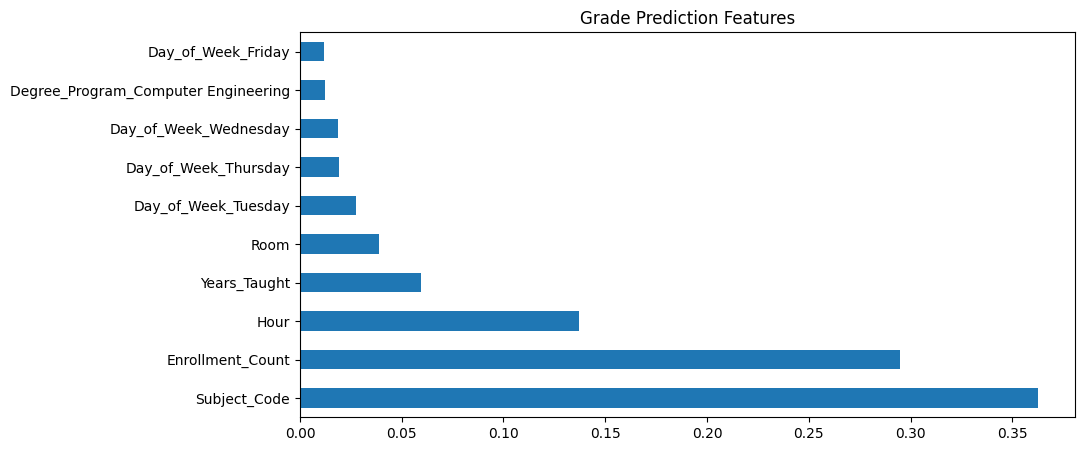

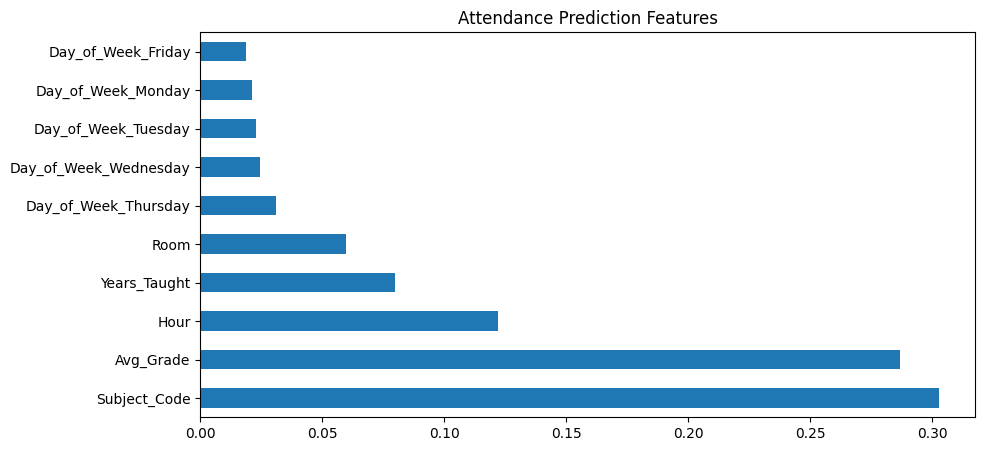

In [36]:
import matplotlib.pyplot as plt

def plot_importance(model, features, title):
    plt.figure(figsize=(10,5))
    importances = pd.Series(model.feature_importances_, index=features)
    importances.nlargest(10).plot(kind='barh')
    plt.title(title)
    plt.show()

plot_importance(rf_grade, X_reg.columns, "Grade Prediction Features")
plot_importance(rf_attend, X_clf.columns, "Attendance Prediction Features")

## 5. Generate Recommendations

In [37]:
importances_reg = rf_grade.feature_importances_
# Top features impacting grades
top_features_grade = pd.Series(importances_reg, index=X_reg.columns).sort_values(ascending=False).head(3)
print("Top factors for higher grades:")
for feature, importance in top_features_grade.items():
    print(f"- {feature}: {importance:.2%}")

Top factors for higher grades:
- Subject_Code: 36.27%
- Enrollment_Count: 29.46%
- Hour: 13.69%


In [38]:
importances_clf = rf_attend.feature_importances_
# Top features impacting attendance
top_features_attendance = pd.Series(importances_clf, index=X_clf.columns).sort_values(ascending=False).head(3)
print("\nTop factors for high attendance:")
for feature, importance in top_features_attendance.items():
    print(f"- {feature}: {importance:.2%}")


Top factors for high attendance:
- Subject_Code: 30.26%
- Avg_Grade: 28.68%
- Hour: 12.20%
